In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime



In [2]:
anime_df = pd.read_csv(r"C:\Users\sydne\Desktop\Springboard\Cap2\Data\anime_data.csv")

In [3]:
anime_df.drop(['anime_id', 'title', 'created_at', 'real_end_date', 'scored_by', 'status', 'episodes','start_year', 'start_season', 'sfw'], axis =1, inplace= True)



In [4]:
#X = new_anime_df['genres']
#Xtrain, Xtest = train_test_split(X, test_size=0.2, random_state=42)
#encoding_dict = Xtrain.value_counts(normalize=True).to_dict()
#X_train_encoded = Xtrain.map(encoding_dict)
#X_test_encoded = Xtest.map(encoding_dict)

In [5]:
#print(X_train_encoded)
#print(X_test_encoded)

In [6]:

# Calculate frequency for each category
frequency = anime_df['genres'].value_counts(normalize=True)
# Map categories to frequency values
anime_df['encoded_genres'] = anime_df['genres'].map(frequency)
anime_df['encoded_genres'].fillna(anime_df['encoded_genres'].median(), inplace=True)


In [7]:
#for studios 
frequency = anime_df['studios'].value_counts(normalize=True)
anime_df['encoded_studios'] = anime_df['studios'].map(frequency)
anime_df['encoded_studios'].fillna(anime_df['encoded_studios'].median(), inplace=True)

In [8]:
frequency = anime_df['producers'].value_counts(normalize=True)
anime_df['encoded_pros'] = anime_df['producers'].map(frequency)
anime_df['encoded_pros'].fillna(anime_df['encoded_pros'].median(), inplace=True)

In [9]:
frequency = anime_df['licensors'].value_counts(normalize=True)
anime_df['encoded_lic'] = anime_df['licensors'].map(frequency)
anime_df['encoded_lic'].fillna(anime_df['encoded_lic'].median(), inplace=True)

In [10]:
frequency = anime_df['themes'].value_counts(normalize=True)
anime_df['encoded_themes'] = anime_df['themes'].map(frequency)
anime_df['encoded_themes'].fillna(anime_df['encoded_themes'].median(), inplace=True)

In [11]:
frequency = anime_df['demographics'].value_counts(normalize=True)
anime_df['encoded_demos'] = anime_df['demographics'].map(frequency)
anime_df['encoded_demos'].fillna(anime_df['encoded_demos'].median(), inplace=True)


In [12]:
frequency = anime_df['rating'].value_counts(normalize=True)
anime_df['encoded_rat'] = anime_df['rating'].map(frequency)
anime_df['encoded_rat'].fillna(anime_df['encoded_rat'].median(), inplace=True)

In [13]:
frequency = anime_df['source'].value_counts(normalize=True)
anime_df['encoded_source'] = anime_df['source'].map(frequency)
anime_df['encoded_source'].fillna(anime_df['encoded_source'].median(), inplace=True)

In [14]:
frequency = anime_df['type'].value_counts(normalize=True)
anime_df['encoded_type'] = anime_df['type'].map(frequency)
anime_df['encoded_type'].fillna(anime_df['encoded_type'].median(), inplace=True)

In [15]:
anime_df.drop(['genres', 'type', 'themes', 'rating', 'studios', 'producers', 'licensors', 'source', 'demographics'], axis= 1, inplace=True)

In [25]:
X = anime_df.drop('score', axis =1)
y = anime_df['score']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=42)

## Scale Data

In [26]:
scaler = StandardScaler()
scaler.fit(Xtrain)
X_tr_scaled = scaler.transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

Use Linear Regression model

In [27]:
lm =LinearRegression().fit(X_tr_scaled, ytrain)

In [28]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_test_scaled)

Assess model performance

In [29]:
r2_score(ytrain, y_tr_pred), r2_score(ytest, y_te_pred)

(0.18449757490035612, 0.18203162757452784)

In [30]:
median_mae = mean_absolute_error(ytrain, y_tr_pred), mean_absolute_error(ytest, y_te_pred)
median_mae

(0.6431530449534858, 0.6385759099783941)

In [31]:
test_score = lm.score(X_test_scaled, ytest)
print("Test Set Accuracy: {}".format(test_score))


Test Set Accuracy: 0.18203162757452784


Let's refine the Linear Regression 

In [56]:
pipe = make_pipeline( SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func = f_regression, k=5),
    LinearRegression()
)

In [57]:
X2 = anime_df.drop('score', axis =1)
y2 = anime_df['score']
X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=0.3, random_state=42)
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001E4ADBBBE20>)),
                ('linearregression', LinearRegression())])

In [58]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [59]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.16999758636857232, 0.1645479109795932)

In [60]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.6486347423904637, 0.6449799203061911)

Perform cross_validation

In [61]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)

In [62]:
cv_scores = cv_results['test_score']
cv_scores

array([0.16866082, 0.16129898, 0.14942024, 0.18046253, 0.18266824])

In [63]:
np.mean(cv_scores), np.std(cv_scores)

(0.1685021607351655, 0.012326871104038871)

Random Forest Model

In [65]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=45)
)

In [66]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv =5)

In [67]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.52773   , 0.52073837, 0.52772355, 0.51862323, 0.51690229])

In [68]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.5223434872136519, 0.004560328254774246)

In [70]:
RF_pipe.fit(X_train,y_train)
y_tr_pred = RF_pipe.predict(X_train)
y_te_pred = RF_pipe.predict(X_test)

In [71]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.9169472830496015, 0.5397528753581161)

In [72]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.193328254628245, 0.4597511871204822)

HyperParameters

In [73]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [74]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [75]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=45))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [76]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 483,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

In [77]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.53057772, 0.52443444, 0.5289944 , 0.52622318, 0.52125274])

In [78]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.5262964968475985, 0.003302112628144501)

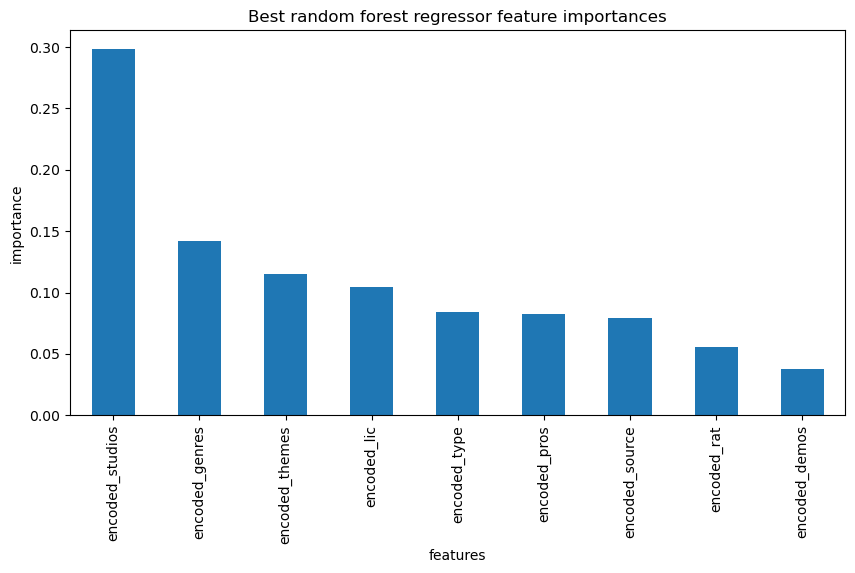

In [79]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');